# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [35]:
# Python Standard Library
# -----------------------
pass

In [36]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [37]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [38]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [39]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [40]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [41]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [42]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

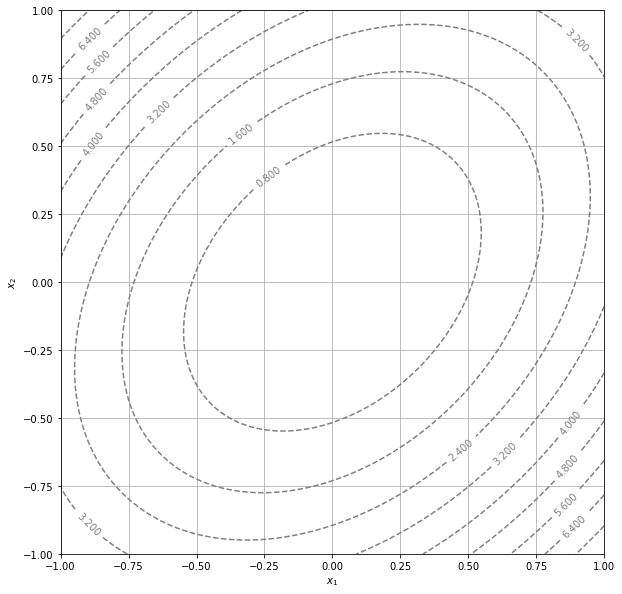

In [43]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [44]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

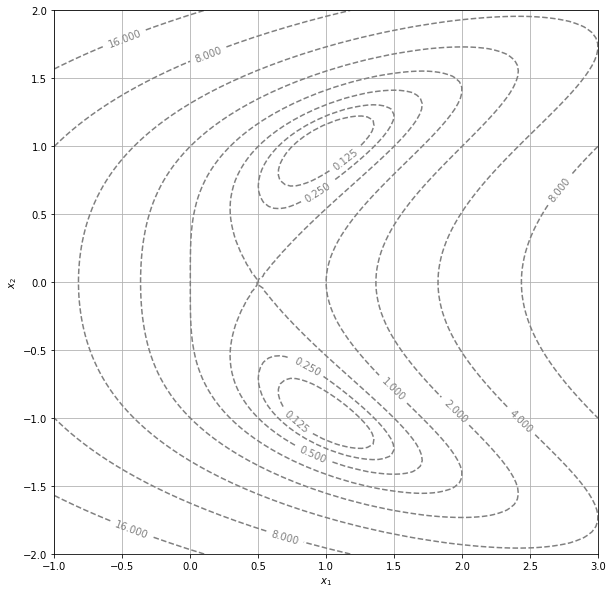

In [45]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [46]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

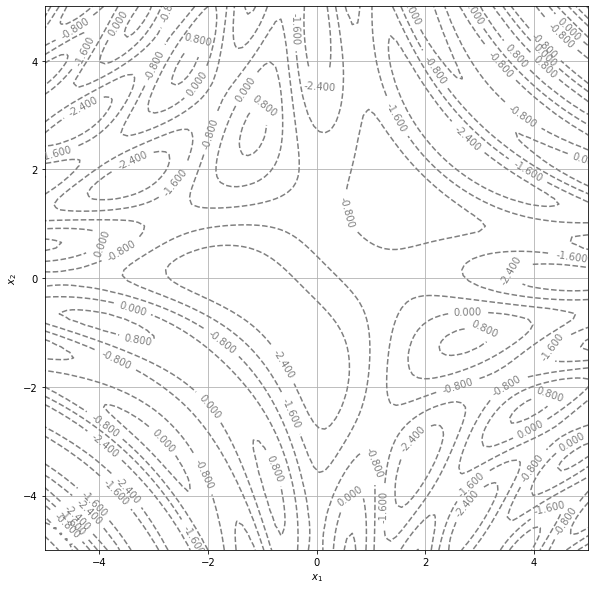

In [47]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse 1

L'ensemble de niveau $c$ de $f$ est l'image réciproque par $f$, qui est continue, du singleton $\{c\}$ donc est fermé. De plus, cet ensemble est borné. En effet, puisque $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, il existe $r \in \mathbb{R}$ tel que pour tout $(x_1,x_2) \in \mathbb{R}^2$, $\|(x_1,x_2)\| > r \Rightarrow f(x_1,x_2) > c$. Ainsi, l'ensemble de niveau $c$ est inclus dans la boule de rayon $r$ donc est borné. Enfin, nous sommes en dimension finie donc c'est un compact.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$


#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2
Il s'agit du produit scalaire du vecteur $x-x_0$ avec le vecteur unitaire $v$ construit en appliquant une rotation de $\pi/2$ à $\nabla f(x_0)$. Géométriquement, il s'agit donc du projeté de $(x-x_0)$ sur le vecteur $v$. Ainsi, $p(x)$ s'annule lorsque $x-x_0$ est colinéaire à $\nabla f(x_0)$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3
Posons

$\begin{array}{ccccc}
F & : & \mathbb{R}^2 \times \mathbb{R} & \to & \mathbb{R}^2 \\
 & & (x_1, x_2, t) & \mapsto & (f(x_1,x_2)-c, p(x_1, x_2)-t) \\
\end{array}$.

Alors $F$ est continûement différentiable. En effet, $f$ et $p$ le sont (car $p$ est linéaire) donc par addition et par assemblage, $F$ est continûement différentiable.

De plus, $\partial_xF$ est inversible sur un voisinage de $x_0$. En effet, $\partial_xF (y)=\begin{pmatrix} {\partial_1 f} (y) & {\partial_2 f} (y) \\ \frac{\partial_2 f}{\|\nabla f(x_0)\|} (x_0) & -\frac{\partial_1 f}{\|\nabla f(x_0)\|} (x_0) \end{pmatrix}$ et $\text{det} (\partial_xF (y)) = - \nabla f(x_0) \nabla f(y) \neq 0$ dans un voisinage de $0$ car le gradient est non nul en $x_0$ et le déterminant est continu.

Enfin, $F$ s'annule en $(x_0,p(x_0))$.

On peut donc appliquer le théorème des fonctions implicites à $F$ : il existe des voisinages $U$ de $x_0$ et $V$ de $p(x_0)=0$ et une fonction continûment différentiable $\gamma : V \rightarrow \mathbb{R}^2$ tels que : $f(x_1,x_2)=c$ et  $t=p(x_1,x_2)$ si, et seulement si, $(x_1,x_2)=\gamma(t)$.

Puisque $V$ est ouvert (et non vide), il existe bien $\varepsilon >0$ tel que $]-\varepsilon, \varepsilon [ \subset V$ et la propriété est vérifiée sur cet intervalle.


#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse 4

Pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ : $\gamma'(t) = 0 \iff d\gamma(t)=0$. Or, en se fixant $t\in \left]-\varepsilon, \varepsilon \right[$, le théorème des foncions implicites donne $d\gamma(t)=-(\partial_xF(x,t))^{-1}.\partial_tF(x,t)$ où $x=\gamma(t)$.

On calcule alors : 

$\gamma'(t)= -M(x,t)^{-1} \begin{pmatrix} 0 \\ -1 \end{pmatrix}$ ($M$ est la matrice associée à $\partial_xF$)

$\gamma'(t)=\frac{1}{det(M(x,t))}\begin{pmatrix}-\partial_2f(x)\\\partial_1f(x)\end{pmatrix}$ qui est non nul puisque le gradient est non nul et $M$ inversible.

De plus, on calcule le produit scalaire :

$\nabla f(\gamma(t)).\gamma'(t)=\frac{1}{det(M(x,t))}\begin{pmatrix}-\partial_2f(x)\\\partial_1f(x)\end{pmatrix}.\begin{pmatrix}\partial_1f(x)\\\partial_2f(x)\end{pmatrix}=0$

donc le vecteur $γ′(t)$ est bien orthogonal à $∇f(γ(t))$ pour tout $t \in \left]-\varepsilon, \varepsilon \right[$.


## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [48]:
N = 100
eps = .0001

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [49]:
def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        jacobienne=J(F)(x0,y0)
        a0=np.array([x0,y0])
        x,y=a0-np.dot(np.linalg.inv(jacobienne),F(x0,y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

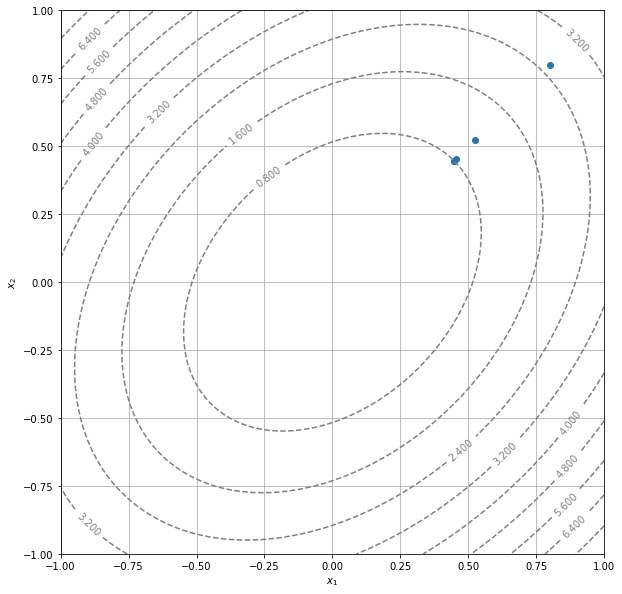

In [58]:
#Afin de représenter graphiquement les résultats, on crée une fonction qui se base sur la précédente et qui affiche le point généré à chaque itération, ce qui montre la convergence de la méthode.
def Newton_graphique_conv(F, x0, y0, eps=eps, N=N):
    Lx=[x0]
    Ly=[y0]
    for i in range(N):
        jacobienne=J(F)(x0,y0)
        a0=np.array([x0,y0])
        x,y=a0-np.dot(np.linalg.inv(jacobienne),F(x0,y0))
        Lx.append(x)
        Ly.append(y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            display_contour(
                f1,  
                x=np.linspace(-1.0, 1.0, 100), 
                y=np.linspace(-1.0, 1.0, 100),
                levels=10
            )
            plt.scatter(Lx,Ly)
            plt.show()
            return
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

def F1(x1,x2):
    return np.array([f1(x1,x2)-.8,x1-x2])

def F2(x1,x2):
    return np.array([f2(x1,x2)-4,x1-x2])

Newton_graphique_conv(F1,.8,.8)

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

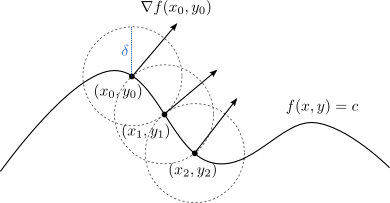

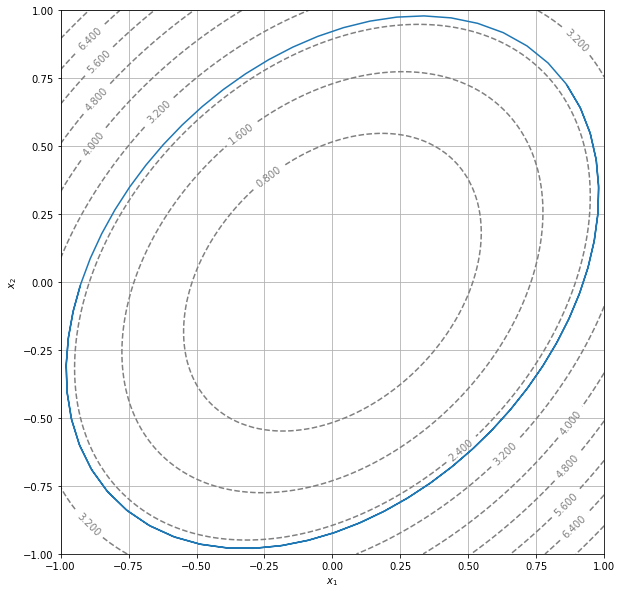

In [51]:
def norm(x):
   x1,x2=x
   return np.sqrt(x1**2 + x2**2)

#Fonction qui renvoie le vecteur tourné de -pi/2
def rot_right(u) :
    x,y=u
    return np.array([y, -x])

def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
   T=np.zeros(shape=(2,N))
   c=f(x0,y0)
   x,y=x0,y0
   def F(x,y):
      return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
   for i in range(N) :
      gr=grad(f)(x0,y0)
      gr_delta=(delta/norm(gr))*gr
      vect=rot_right(gr_delta)
      a0 = np.array([x0,y0])
      x,y = a0 + vect
      x,y = Newton(F, x, y)
      x0,y0=x,y
      T[0][i],T[1][i]=x0,y0
   return T

# On réutilise la fonction précédente afin de tracer la courbe
def level_curve_graph(f, x0, y0, delta=0.1, N=1000, eps=eps):
    T=level_curve(f,x0,y0,delta,N,eps)
    Lx,Ly=[],[]
    for point in T[0]:
        Lx.append(point)
    for point in T[1]:
        Ly.append(point)
    display_contour(
        f, 
        x=np.linspace(-1.0, 1.0, 100), 
        y=np.linspace(-1.0, 1.0, 100), 
        levels=10
    )
    plt.plot(Lx,Ly)
    plt.show()

level_curve_graph(f1,.8,.8,.1,100)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [52]:
#fonction qui dit si deux segments [a,b] et [c,d] s'intersectent :
def seg_inter(ax,ay,bx,by,cx,cy,dx,dy):
    if ax > bx :
        ax,ay,bx,by=bx,by,ax,ay #plus simple pour la suite
    if cx > dx :
        cx,cy,dx,dy=dx,dy,cx,cy
    #on calcule les éq de droites (pente et ordonnée à l'origine)
    pente_ab=(by-ay)/(bx-ax)
    pente_cd=(dy-cy)/(dx-cx)
    ord_ab=ay-pente_ab*ax
    ord_cd=cy-pente_cd*cx
    if pente_ab == pente_cd : #on vérifie s'ils sont parallèles
        return ord_ab == ord_cd
    #on obtient l'abcisse de l'intersection :
    xi=(ord_cd-ord_ab)/(pente_ab-pente_cd)
    return ax <= xi and xi <= bx and cx <= xi and xi <= dx

def level_curve_2(f, x0, y0, delta=0.1, eps=eps):
    L=[[x0,y0]] #on utilise une liste pour pouvoir modifier la taille
    c=f(x0,y0)
    x,y=x0,y0
    def F(x,y):
        return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
    #Pour faire fonctionner la boucle while, on doit d'abord faire trois itérations
    for i in range(3) :
        gr=grad(f)(x0,y0)
        gr_delta=(delta/norm(gr))*gr
        vect=rot_right(gr_delta)
        a0 = np.array([x0,y0])
        x,y = a0 + vect
        x,y = Newton(F, x, y)
        x0,y0=x,y
        L.append([x0,y0])
    k=3
    while seg_inter(L[0][0],L[0][1],L[1][0],L[1][1],L[k-1][0],L[k-1][1],L[k][0],L[k][1])==False:
        gr=grad(f)(x0,y0)
        gr_delta=(delta/norm(gr))*gr
        vect=rot_right(gr_delta)
        a0 = np.array([x0,y0])
        x,y = a0 + vect
        x,y = Newton(F, x, y)
        x0,y0=x,y
        L.append([x0,y0])
        k+=1
    T=np.transpose(np.array(L))
    return T

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

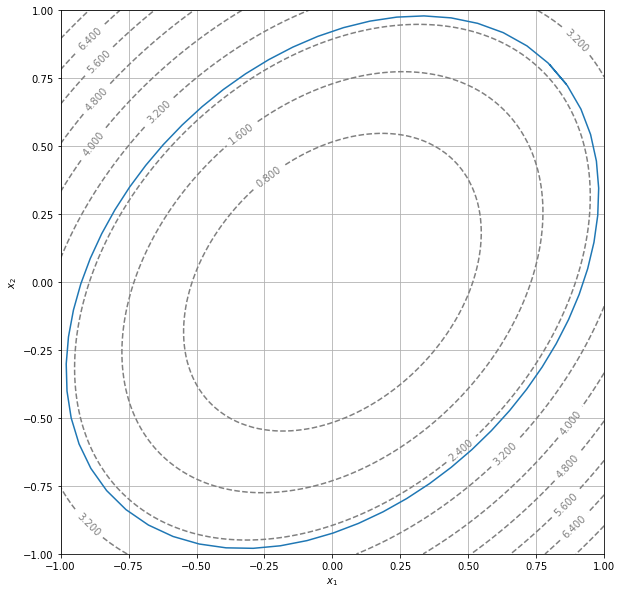

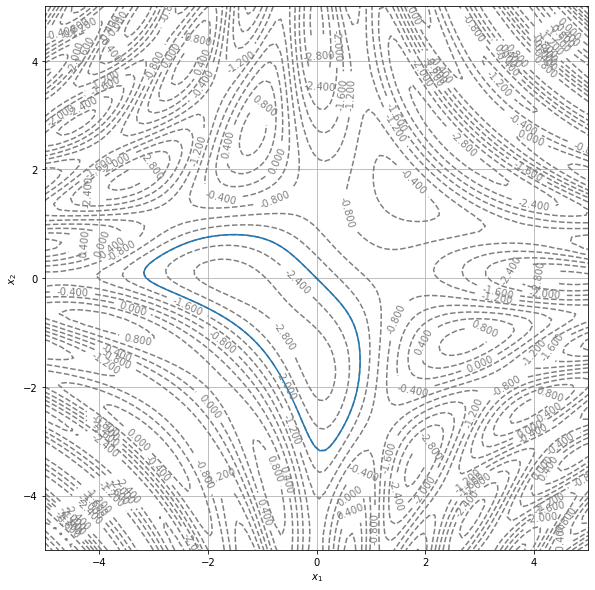

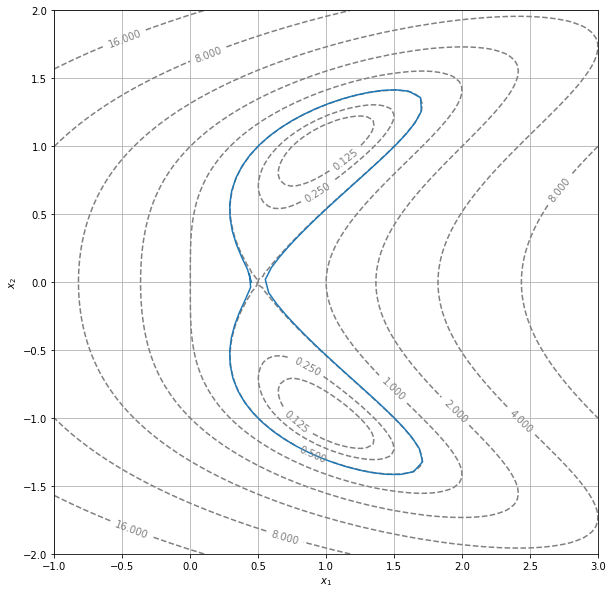

In [53]:
def level_curve_graph_2(f, x0, y0, a, b, delta=0.1, eps=eps):
    T=level_curve_2(f,x0,y0,delta,eps)
    Lx,Ly=[],[]
    for point in T[0]:
        Lx.append(point)
    for point in T[1]:
        Ly.append(point)
    display_contour(
        f, 
        x=np.linspace(a, b, 100), 
        y=np.linspace(a, b, 100), 
        levels=10
    )
    plt.plot(Lx,Ly)
    plt.show()

level_curve_graph_2(f1,.8,.8,-1.0,1.0)
level_curve_graph_2(f3,.0,.0,-5.0,5.0)

#Pour la fonction 2, on réalise une implémentation spécifique afin que le graphe soit plus joli

def level_curve_graph_2_f2(f, x0, y0, delta=0.1, eps=eps):
    T=level_curve_2(f,x0,y0,delta,eps)
    Lx,Ly=[],[]
    for point in T[0]:
        Lx.append(point)
    for point in T[1]:
        Ly.append(point)
    display_contour(
        f, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)]
    )
    plt.plot(Lx,Ly)
    plt.show()

level_curve_graph_2_f2(f2,.45,.0)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8

On note : $P_1 = (x_1;y_1)$ $P_2 = (x_2;y_2)$ $u_1=(\alpha_1;\beta_1)$ $u_2=(\alpha_2;\beta_2)$. Soit $(\lambda,\mu) \in (\mathbb{R}^{*}_{+})^2$ vérifiant $\begin{cases} \gamma'(0)=\lambda u_1 \\ \gamma'(1)=\mu u_2 \end{cases}$

En écrivant les différentes conditions on obtient $a=x_1$, $b=\lambda\alpha_1$, $d=y_1$, $e=\lambda\beta_1$ et le système $\begin{cases} 2c-\alpha_2\mu+\alpha_1\lambda=0 \\ c+\alpha_1\lambda=x_2-x_1 \\ 2f - \beta_2\mu + \beta_1\lambda=0 \\ f +\beta_1\lambda=y_2-y_1 \end{cases}$

Ce système a pour déterminant $\alpha_1\beta_2 - \alpha_2\beta_1$, nul si et seulement si $u_1$ et $u_2$ sont parallèles.

Si ce n'est pas le cas, on obtient après calculs : $\lambda = 2\frac{det(\vec{P_1 P_2}, u_2)}{det(u_1, u_2)}$, $\mu = 2\frac{det(u_1, \vec{P_1P_2})}{det(u_1, u_2)}$, $c=2\alpha_2\frac{det(u_1, \vec{P_1P_2})}{det(u_1, u_2)}-(x_2-x_1)$ et 
$f=2\beta_2\frac{det(u_1, \vec{P_1P_2})}{det(u_1, u_2)}-(y_2-y_1)$. On a donc aussi $b=2\alpha_1\frac{det(\vec{P_1 P_2}, u_2)}{det(u_1, u_2)}$ et $e=2\beta_1\frac{det(\vec{P_1 P_2}, u_2)}{det(u_1, u_2)}$. Tous les coefficients sont déterminés.

$\lambda>0$ et $\mu >0$ impose en outre que $u_1$ et $u_2$ "se trouvent de part et d'autre" de $\vec{P_1 P_2}$.

Si $\alpha_1\beta_2 - \alpha_2\beta_1=0$ $u_1$ et $u_2$ sont colinéaires. Le système impose qu'ils soient aussi colinéaires à $\vec{P_1P_2}$.
 
On peut alors trouver un chemin $\gamma$ qui convient sauf si $u_1$ et $u_2$ ont le même sens, qui n'est pas celui de $\vec{P_1P_2}$.

Si $u_1$ et $u_2$ ont le même sens que $\vec{P_1P_2}$, le segment convient.

Si $u_1$ et $u_2$ n'ont pas le même sens on peut trouver $\lambda$ suffisamment grand pour satisfaire $\mu>0$, si $alpha_1=0$ on choisit $\lambda=2|\frac{y_2-y_1}{beta_1}|+1$, sinon $\lambda=2|\frac{x_2-x_1}{\alpha_1}|+1$. On trouve alors les coefficients a,b,c,d,e et f grâce aux expressions de départ.




#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [54]:
def gamma(t,P1,P2,u1,u2):
    x1,y1=P1
    x2,y2=P2
    a1,b1=u1
    a2,b2=u2
    if a1*b2 != a2*b1 : #cas où u1 et u2 ne sont pas colinéaires
        detu1u2=a1*b2-a2*b1
        detu1P1P2=a1*(y2-y1)-b1*(x2-x1)
        detP1P2u2=b2*(x2-x1)-a2*(y2-y1)
        a=x1
        b=2*a1*detP1P2u2/detu1u2
        c=2*a2*detu1P1P2/detu1u2-(x2-x1)
        d=y1
        e=2*b1*detP1P2u2/detu1u2
        f=2*b2*detu1P1P2/detu1u2-(y2-y1)
        if detP1P2u2*detu1u2 > 0 and detu1P1P2*detu1u2 > 0 : #on vérifie que lambda et mu sont positifs
            return np.array([a+b*t+c*np.power(t,2),d+e*t+f*np.power(t,2)]) #on n'utilise que des fonctions vectorisées
    elif a1*(y_2-y_1)-b1*(x_2-x1)==0 and a1*a2+b2*b1<0: #on vérifie si u1, u2 et P1P2 sont alignés et si u1 et u2 ont des sens différents
        if a1==0:
            lambd=2*np.abs((y2-y1)/b1)+1
            mu=((2*(y2-y1)/b1)-lambd)/(b2/b1)
        else :
            lambd=2*np.abs((x2-x1)/a1)+1
            mu=((2*(x2-x1)/a1)-lambd)/(a2/a1)
        a=x1
        b=lambd*a1
        c=x2-x1-b
        d=y1
        e=lambd*b1
        f=y2-y1-e
        return np.array([a+b*t+c*np.power(t,2),d+e*t+f*np.power(t,2)])
    return np.array([x1+t*(x2-x1),y1+t*(y2-y1)])

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [55]:
def level_curve_3(f, x0, y0, delta=0.1, eps=eps, oversampling=1):
    L=[[x0,y0]] #on utilise une liste pour pouvoir modifier la taille
    c=f(x0,y0)
    x,y=x0,y0
    def F(x,y):
        return np.array([f(x,y)-c, (x-x0)**2 + (y-y0)**2 - delta**2])
    #Pour faire fonctionner la boucle while, on doit d'abord faire trois itérations
    for i in range(3) :
        gr=grad(f)(x0,y0)
        gr_delta=(delta/norm(gr))*gr
        vect=rot_right(gr_delta)
        a0 = np.array([x0,y0])
        x,y = a0 + vect
        x,y = Newton(F, x, y)
        for j in range(oversampling):
            L.append(gamma((j+1)/oversampling,a0,np.array([x,y]),rot_right(gr),rot_right(grad(f)(x,y))))
        x0,y0=x,y
    k=3*oversampling
    #On ne teste que les segments dont les extrémités ont été créés par la méthode de Newton  (donc pas ceux créés grâce à gamma)
    while seg_inter(L[0][0],L[0][1],L[oversampling][0],L[oversampling][1],L[k-oversampling][0],L[k-oversampling][1],L[k][0],L[k][1])==False:
        gr=grad(f)(x0,y0)
        gr_delta=(delta/norm(gr))*gr
        vect=rot_right(gr_delta)
        a0 = np.array([x0,y0])
        x,y = a0 + vect
        x,y = Newton(F, x, y)
        for j in range(oversampling):
            L.append(gamma((j+1)/oversampling,a0,np.array([x,y]),rot_right(gr),rot_right(grad(f)(x,y))))
        x0,y0=x,y
        k+=oversampling
    return np.transpose(np.array(L))

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

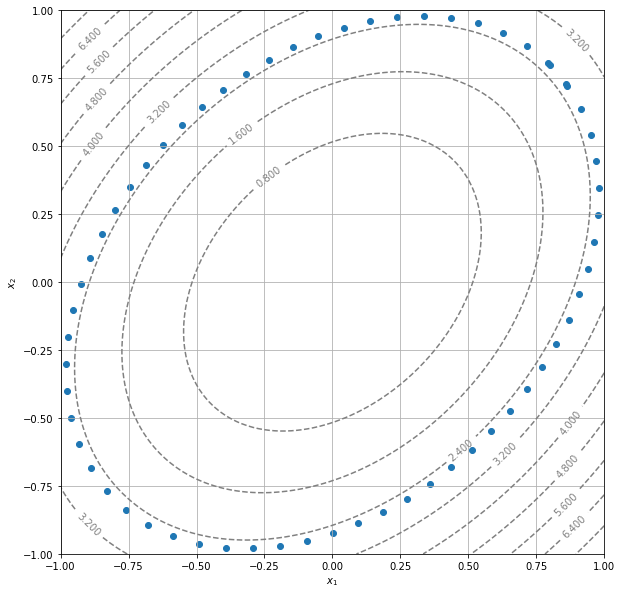

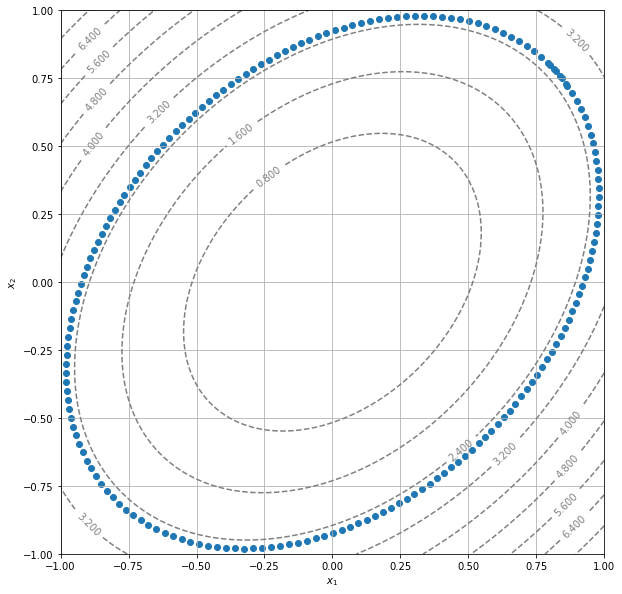

In [57]:
def level_curve_graph_3(f, x0, y0, a, b, delta=.1, eps=eps, oversampling=1):
    T=level_curve_3(f,x0,y0,delta,eps,oversampling)
    Lx,Ly=[],[]
    for point in T[0]:
        Lx.append(point)
    for point in T[1]:
        Ly.append(point)
    display_contour(
        f, 
        x=np.linspace(a, b, 100), 
        y=np.linspace(a, b, 100), 
        levels=10
    )
    plt.scatter(Lx,Ly)
    plt.show()

level_curve_graph_3(f1,.8,.8,-1.0,1.0,.1,.00001,1)
level_curve_graph_3(f1,.8,.8,-1.0,1.0,.1,.00001,3)